# CytoData 2023 Hackathon

This is an example Notebook that presents how the hackathon data can be used.

In [1]:
# Import used libraries
import os
import re
import random
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics
import umap
import umap.plot
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

2023-10-25 11:18:13.491076: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Define needed paths
root_path = Path('/').joinpath(*Path(os.getcwd()).parts[1:3])
img_path = root_path / 'images'
meta_path = root_path / 'metadata'
trainfeat_path = meta_path / 'cytodata2023_hackathon_features_train.csv'
testfeat_path = meta_path / 'cytodata2023_hackathon_features_test.csv'
trainmeta_path = meta_path / 'cytodata2023_hackathon_train.csv'
testmeta_path = meta_path / 'cytodata2023_hackathon_test.csv'
channels = ['1_AF488', '1_AF555', '1_AF647', '1_AF750', '1_DAPI', '2_AF647']

## Helper functions

In [3]:
def crop_rgb_tiles(img, cshape, rand_boxes=0):
    boxes = []
    if rand_boxes > 0:
        for i in range(rand_boxes):
            boxes.append((np.random.randint(0,img.shape[0]-cshape[0]), np.random.randint(0,img.shape[1]-cshape[1])))
    else:
        boxes = [(y,x) for x in range((img.shape[1]%cshape[1])//2, img.shape[1]-cshape[1], cshape[1])
                 for y in range((img.shape[0]%cshape[0])//2, img.shape[0]-cshape[0], cshape[0])]
    
    tiles = np.zeros((len(boxes),cshape[0],cshape[1],3), dtype=np.float32)
    for i,(sx,sy) in enumerate(boxes):
        cimg = img[sy:sy+cshape[0], sx:sx+cshape[1]]
        tiles[i,:,:,0] = cimg
        tiles[i,:,:,1] = cimg
        tiles[i,:,:,2] = cimg
    
    return tiles

## Read and check metadata and features

In [4]:
df_metadata_train = pd.read_csv(trainmeta_path)
df_features_train = pd.read_csv(trainfeat_path)

In [5]:
# Check metadata
df_metadata_train

,Slide,ROI number,PatientID,Location,Annotation Color,Progression,pT,Fuhrman
0,TMA-06,29,1,3,Blue2,1,3,2
1,TMA-09,66,2,2,Red1,1,2,3
2,TMA-07,67,4,3,Blue1,1,3,3
3,TMA-03,52,8,3,Blue2,0,3,2
4,TMA-06,27,1,2,Red2,1,3,2
...,...,...,...,...,...,...,...,...
237,TMA-04,127,68,2,Red1,0,1,1
238,TMA-01,11,58,2,Red1,0,1,2
239,TMA-03,124,34,3,Blue2,0,1,2
240,TMA-07,107,23,3,Blue1,1,1,2


In [6]:
# Check features
df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_MedianIntensity_Fap,Intensity_MedianIntensity_Pdgfra,Intensity_MedianIntensity_Pdgfrb,Intensity_MedianIntensity_Sma,Intensity_UpperQuartileIntensity_Dapi,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.010697,0.004280,0.010742,0.004524,0.023926,0.073678,0.014145,0.004990,0.013458,0.005539
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.007980,0.003830,0.007645,0.003494,0.127466,0.042306,0.009567,0.004273,0.008797,0.003876
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.008995,0.004883,0.009651,0.003799,0.067735,0.055001,0.013588,0.005570,0.011788,0.004410
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.009384,0.004288,0.068093,0.007568,0.123033,0.051465,0.013287,0.004776,0.099508,0.013188
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.037697,0.005173,0.015709,0.005997,0.103346,0.027802,0.053239,0.006271,0.032040,0.010449
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.006096,0.003174,0.004852,0.002823,0.057225,0.021050,0.007000,0.003857,0.005947,0.003220
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.009071,0.003754,0.006859,0.003494,0.041238,0.023980,0.011872,0.004395,0.008614,0.004223
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.008042,0.002655,0.004730,0.002777,0.017174,0.027977,0.011040,0.003418,0.007980,0.003799
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.011765,0.005142,0.011429,0.005165,0.083185,0.087358,0.015732,0.006256,0.016266,0.006222
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.008728,0.004402,0.009422,0.003906,0.052129,0.071202,0.010986,0.005005,0.011402,0.004410


In [7]:
# Merge features and metadata, drop 'Annotation Color' columns
df_features_train = df_features_train.merge(df_metadata_train, on=['Slide','ROI number'], how='left')
df_features_train = df_features_train.drop('Annotation Color', axis=1)
df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Progression,pT,Fuhrman
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.073678,0.014145,0.004990,0.013458,0.005539,58,2,0,1,2
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.042306,0.009567,0.004273,0.008797,0.003876,58,2,0,1,2
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.055001,0.013588,0.005570,0.011788,0.004410,58,2,0,1,2
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.051465,0.013287,0.004776,0.099508,0.013188,58,2,0,1,2
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.027802,0.053239,0.006271,0.032040,0.010449,58,2,0,1,2
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.021050,0.007000,0.003857,0.005947,0.003220,58,2,0,1,2
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.023980,0.011872,0.004395,0.008614,0.004223,58,2,0,1,2
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.027977,0.011040,0.003418,0.007980,0.003799,58,2,0,1,2
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.087358,0.015732,0.006256,0.016266,0.006222,58,2,0,1,2
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.071202,0.010986,0.005005,0.011402,0.004410,58,2,0,1,2


## Visualize images

Open a random core and visualize it.

In [8]:
idx = df_metadata_train.sample(n=1).index[0]
imgpaths = img_path.glob(df_metadata_train.loc[idx,'Slide']+'*roi{:03d}*'.format(df_metadata_train.loc[idx,'ROI number']))
imgpaths = [x for x in imgpaths]
imgpaths.sort()

/run/nvme/job_19107805/tmp/ipykernel_2164117/865043981.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


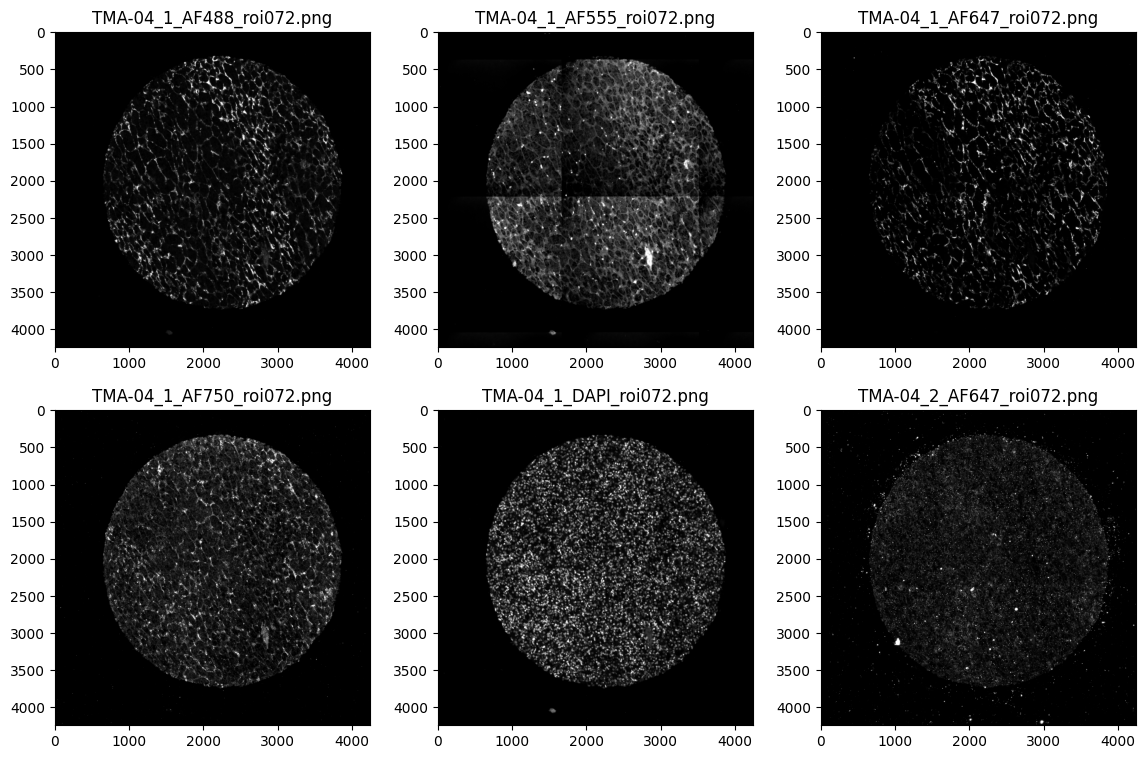

In [9]:
# There should be 6 images to view
rows = 2
cols = 3
fig,ax = plt.subplots(rows,cols,figsize=(14,9))
for i,ipath in enumerate(imgpaths):
    img = imageio.imread(ipath).astype(np.float32)
    # Scale images from median (bg) to 0.998 quantile for visualization
    intlow,inthigh = np.quantile(img,[0.5,0.998])
    img = (img - intlow) / (inthigh-intlow)
    img[img<0.0] = 0.0
    img[img>1.0] = 1.0
    img = (img * 255.0).astype(np.uint8)
    ax[i//cols, i%cols].imshow(img, cmap='gray')
    ax[i//cols, i%cols].set_title(ipath.name)

## Classical features

### Preprocess features

In [10]:
# Feature columns
featcols = [x for x in df_features_train.columns if 'Intensity' in x]

In [11]:
# drop NA
prep_features = df_features_train.dropna()

In [12]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(prep_features[featcols])
prep_features.loc[:,featcols] = scaler.transform(prep_features[featcols])
prep_features = prep_features.dropna()

In [13]:
# Visualize 10% of the single-cell features of training data
mapper = umap.UMAP()
umap_sample = prep_features[featcols].sample(frac=0.1)
mapper.fit(umap_sample)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

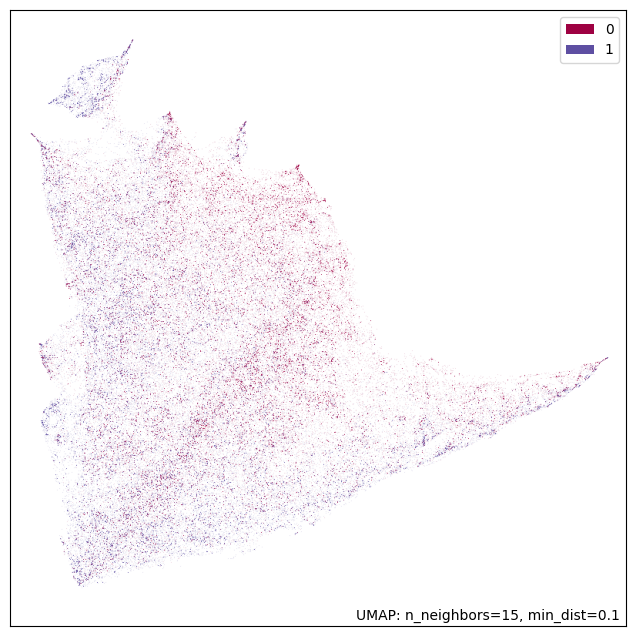

In [14]:
umap.plot.points(mapper, labels=prep_features.loc[umap_sample.index,'Progression'])

<Axes: >

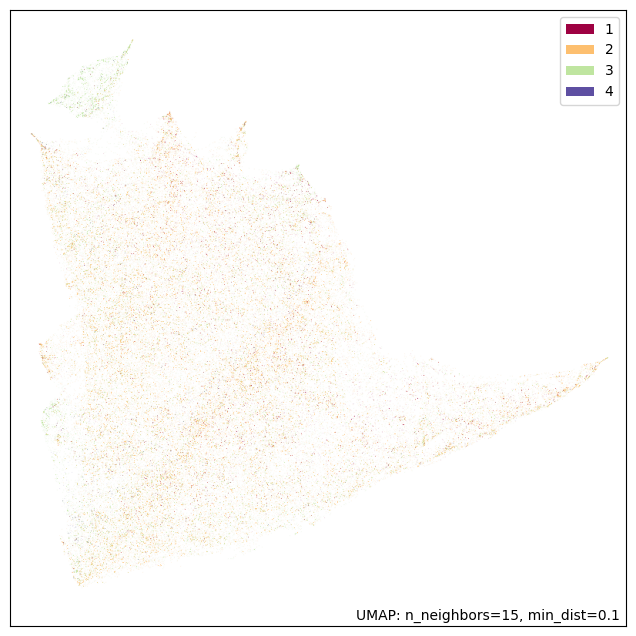

In [22]:
umap.plot.points(mapper, labels=prep_features.loc[umap_sample.index,'Fuhrman'])

Accuracy: 0.6164383561643836


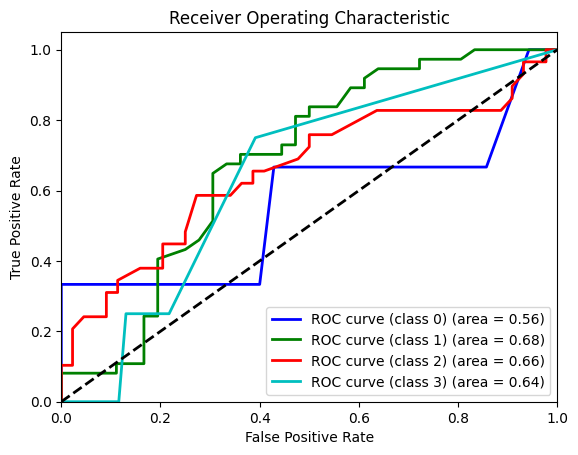

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Median features for each ROI
med_features = prep_features.groupby(['Slide', 'ROI number']).median().reset_index()

# Encode the 'Fuhrman' column into integer labels
label_encoder = LabelEncoder()
med_features['Fuhrman'] = label_encoder.fit_transform(med_features['Fuhrman'])

# Split the data into train and test sets
X = med_features[featcols]
y = med_features['Fuhrman']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict the classes for the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot ROC AUC curve for each class
n_classes = 4  # Four classes (1, 2, 3, and 4)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    y_test_class_i = (y_test == i).astype(int)
    y_score = model.predict_proba(X_test)[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_test_class_i, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['b', 'g', 'r', 'c']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (class {0}) (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Toy classification example

In [16]:
# Median features for each ROI
med_features = prep_features.groupby(['Slide','ROI number']).median().reset_index()

In [17]:
# Use single-cell features for classification
# Sample 30% to validation
X_train = med_features[featcols].sample(frac=0.7)
y_train = med_features.loc[X_train.index,'Progression']
X_test = med_features.loc[~med_features.index.isin(X_train.index),featcols]
y_test = med_features.loc[X_test.index,'Progression']

In [18]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [20]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.863
Precision: 0.818
Recall: 0.871


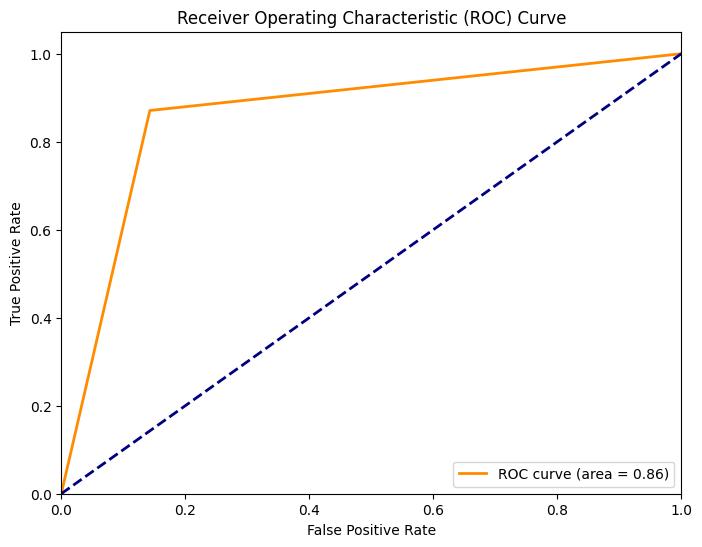

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## DL features with pretrained network

In [20]:
input_shape = (256,256,3)
dl_featcols = ['feat_{}'.format(x) for x in range(2048)]

In [21]:
# Check channel distributions for preprocessing using 20% of images (NOTE: mixes train and test images)
ch_dist = {}
for ch in channels:
    files = [x for x in img_path.glob(f'*{ch}*')]
    files = random.choices(files, k=int(len(files)*0.2))
    dist = np.zeros((len(files),2), dtype=np.float32)
    for i,fpath in tqdm(enumerate(files)):
        img = imageio.imread(fpath)
        dist[i,0] = img.mean()
        dist[i,1] = img.std()
    ch_dist[ch] = (np.mean(dist[:,0]), np.mean(dist[:,1]))

0it [00:00, ?it/s]/run/nvme/job_19020370/tmp/ipykernel_2202001/3726642706.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fpath)
76it [00:40,  1.88it/s]
76it [00:37,  2.05it/s]
76it [00:40,  1.90it/s]
76it [00:39,  1.92it/s]
76it [00:40,  1.86it/s]
76it [00:53,  1.43it/s]


In [22]:
ch_dist

{'1_AF488': (633.6294, 1201.7983),
 '1_AF555': (167.45404, 232.69421),
 '1_AF647': (680.13715, 1955.363),
 '1_AF750': (290.43118, 332.38123),
 '1_DAPI': (1468.5857, 2054.7656),
 '2_AF647': (1625.0994, 3330.273)}

In [23]:
# Load pretrained model
resnet = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')
resnet.summary()

2023-10-18 15:52:04.223592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:52:07.283897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30977 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [24]:
# Extract features separately for each image, sample 64 boxes per image, not optimized as uses GPU only for the prediction
num_boxes = 64
df_dlrois = []
for idx,row in tqdm(df_metadata_train.iterrows()):
    ipaths = img_path.glob(row['Slide']+'*roi{:03d}*'.format(row['ROI number']))
    pat = re.compile('{}_(\d_\w+)_roi{:03d}.png'.format(row['Slide'],row['ROI number']))
    df_dlchs = []
    for ipath in ipaths:
        ch = pat.match(ipath.name).group(1)
        img = imageio.imread(ipath).astype(np.float32)
        img = (img - ch_dist[ch][0]) / ch_dist[ch][1]
        tiles = crop_rgb_tiles(img, input_shape, rand_boxes=num_boxes)
        feat = np.zeros((tiles.shape[0],2048), dtype=np.float32)
        feat = resnet.predict(tiles)
        df_dlroi = pd.DataFrame(columns=[ch+'_'+x for x in dl_featcols], data=feat)
        df_dlchs.append(df_dlroi)
    df_dlch = pd.concat(df_dlchs, axis=1)
    df_dlch['Slide'] = row['Slide']
    df_dlch['ROI number'] = row['ROI number']
    df_dlrois.append(df_dlch)
df_dlfeat = pd.concat(df_dlrois)

0it [00:00, ?it/s]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)
2023-10-18 15:52:14.463470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-10-18 15:52:17.626208: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


2/2 [==============================] - 0s 37ms/step


1it [00:16, 16.09s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


2it [00:20,  9.25s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


3it [00:24,  6.92s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


4it [00:28,  5.82s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


5it [00:33,  5.28s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


6it [00:37,  5.05s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


7it [00:42,  4.94s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


8it [00:46,  4.72s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


9it [00:50,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


10it [00:55,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


11it [00:59,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


12it [01:03,  4.35s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


13it [01:08,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


14it [01:12,  4.42s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


15it [01:16,  4.36s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


16it [01:21,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


17it [01:25,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


18it [01:30,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


19it [01:34,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


20it [01:39,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


21it [01:44,  4.57s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 39ms/step


22it [01:48,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


23it [01:52,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


24it [01:57,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


25it [02:01,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


26it [02:05,  4.42s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


27it [02:10,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 36ms/step


28it [02:15,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


29it [02:19,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


30it [02:23,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


31it [02:28,  4.42s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


32it [02:33,  4.78s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 40ms/step


33it [02:41,  5.75s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


34it [02:46,  5.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


35it [02:51,  5.14s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


36it [02:55,  4.92s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


37it [03:00,  4.89s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


38it [03:04,  4.78s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


39it [03:09,  4.67s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


40it [03:13,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


41it [03:17,  4.37s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


42it [03:22,  4.63s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


43it [03:27,  4.57s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


44it [03:31,  4.58s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


45it [03:36,  4.62s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


46it [03:40,  4.61s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


47it [03:45,  4.57s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


48it [03:49,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


49it [03:54,  4.48s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


50it [03:58,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


51it [04:03,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


52it [04:07,  4.53s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


53it [04:12,  4.57s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


54it [04:17,  4.60s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


55it [04:21,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


56it [04:26,  4.74s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


57it [04:31,  4.68s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


58it [04:35,  4.61s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


59it [04:40,  4.61s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


60it [04:44,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


61it [04:49,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


62it [04:53,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


63it [04:58,  4.48s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


64it [05:02,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


65it [05:07,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


66it [05:11,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


67it [05:15,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


68it [05:20,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


69it [05:25,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


70it [05:29,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


71it [05:33,  4.50s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


72it [05:38,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


73it [05:43,  4.63s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


74it [05:48,  4.62s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


75it [05:52,  4.65s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


76it [05:57,  4.63s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


77it [06:01,  4.57s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


78it [06:06,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


79it [06:10,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


80it [06:14,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


81it [06:18,  4.32s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


82it [06:23,  4.38s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


83it [06:27,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


84it [06:32,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


85it [06:37,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


86it [06:41,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


87it [06:46,  4.60s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


88it [06:51,  4.74s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


89it [06:56,  4.69s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


90it [07:00,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


91it [07:04,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


92it [07:09,  4.67s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


93it [07:14,  4.58s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


94it [07:18,  4.42s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


95it [07:22,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


96it [07:27,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


97it [07:31,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


98it [07:36,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


99it [07:40,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 39ms/step


100it [07:45,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


101it [07:50,  4.58s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


102it [07:54,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


103it [07:58,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


104it [08:03,  4.60s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 39ms/step


105it [08:08,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


106it [08:12,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


107it [08:17,  4.65s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


108it [08:21,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


109it [08:26,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


110it [08:31,  4.57s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


111it [08:35,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


112it [08:40,  4.66s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


113it [08:44,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


114it [08:49,  4.63s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


115it [08:53,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


116it [08:58,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


117it [09:02,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


118it [09:07,  4.47s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


119it [09:11,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


120it [09:16,  4.50s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


121it [09:20,  4.50s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


122it [09:25,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


123it [09:29,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


124it [09:34,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


125it [09:38,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


126it [09:42,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 36ms/step


127it [09:47,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 41ms/step


128it [09:51,  4.34s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


129it [09:56,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


130it [10:00,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


131it [10:05,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


132it [10:09,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


133it [10:14,  4.53s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


134it [10:18,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


135it [10:23,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


136it [10:28,  4.66s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


137it [10:32,  4.62s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


138it [10:37,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


139it [10:42,  4.66s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


140it [10:46,  4.65s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


141it [10:51,  4.65s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


142it [10:55,  4.59s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


143it [11:00,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


144it [11:04,  4.50s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


145it [11:09,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


146it [11:13,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


147it [11:17,  4.42s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


148it [11:22,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


149it [11:26,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


150it [11:31,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


151it [11:36,  4.70s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


152it [11:41,  4.77s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


153it [11:46,  4.78s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


154it [11:51,  4.93s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 40ms/step


155it [11:56,  4.78s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


156it [12:00,  4.71s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


157it [12:05,  4.67s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


158it [12:10,  4.73s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


159it [12:14,  4.72s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


160it [12:19,  4.75s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


161it [12:24,  4.66s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


162it [12:28,  4.67s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


163it [12:33,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


164it [12:37,  4.48s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


165it [12:41,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


166it [12:46,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


167it [12:50,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


168it [12:54,  4.38s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


169it [12:59,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


170it [13:03,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


171it [13:08,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


172it [13:13,  4.72s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


173it [13:17,  4.62s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


174it [13:22,  4.61s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


175it [13:26,  4.50s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


176it [13:31,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


177it [13:35,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


178it [13:39,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


179it [13:44,  4.37s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


180it [13:48,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


181it [13:52,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


182it [13:57,  4.38s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


183it [14:01,  4.38s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


184it [14:06,  4.51s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


185it [14:11,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


186it [14:15,  4.47s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


187it [14:20,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


188it [14:25,  4.75s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


189it [14:29,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


190it [14:33,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


191it [14:38,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


192it [14:43,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


193it [14:47,  4.58s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


194it [14:52,  4.60s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


195it [14:57,  4.65s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


196it [15:01,  4.62s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


197it [15:06,  4.65s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


198it [15:10,  4.60s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


199it [15:15,  4.53s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


200it [15:19,  4.53s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


201it [15:24,  4.55s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


202it [15:28,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


203it [15:33,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


204it [15:37,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


205it [15:42,  4.47s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


206it [15:46,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


207it [15:51,  4.68s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


208it [15:56,  4.59s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


209it [16:00,  4.49s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


210it [16:04,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


211it [16:09,  4.52s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


212it [16:13,  4.47s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


213it [16:18,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


214it [16:22,  4.40s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


215it [16:27,  4.56s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


216it [16:31,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


217it [16:35,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


218it [16:40,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


219it [16:44,  4.41s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


220it [16:49,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


221it [16:53,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


222it [16:58,  4.42s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


223it [17:02,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


224it [17:06,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


225it [17:11,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


226it [17:15,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


227it [17:20,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


228it [17:24,  4.48s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


229it [17:29,  4.44s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


230it [17:33,  4.45s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


231it [17:37,  4.38s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


232it [17:42,  4.43s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


233it [17:46,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


234it [17:51,  4.47s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 39ms/step


235it [17:56,  4.62s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


236it [18:00,  4.61s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


237it [18:05,  4.54s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


238it [18:09,  4.47s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


239it [18:14,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


240it [18:18,  4.39s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 38ms/step


241it [18:22,  4.46s/it]/run/nvme/job_19020370/tmp/ipykernel_2202001/2720181976.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


2/2 [==============================] - 0s 37ms/step


242it [18:27,  4.58s/it]


### Preprocess and visualize

In [25]:
dl_featcols = [x for x in df_dlfeat.columns if 'feat' in x]
df_dlfeat

,1_AF647_feat_0,1_AF647_feat_1,1_AF647_feat_2,1_AF647_feat_3,1_AF647_feat_4,1_AF647_feat_5,1_AF647_feat_6,1_AF647_feat_7,1_AF647_feat_8,1_AF647_feat_9,...,1_DAPI_feat_2040,1_DAPI_feat_2041,1_DAPI_feat_2042,1_DAPI_feat_2043,1_DAPI_feat_2044,1_DAPI_feat_2045,1_DAPI_feat_2046,1_DAPI_feat_2047,Slide,ROI number
0,0.000000,0.000000,0.055933,0.000000,8.113998,0.000000,0.000000,5.217272,0.555187,0.0,...,0.000000,0.0,0.000000,0.0,0.0,11.560848,0.000000,0.0,TMA-06,29
1,2.402092,0.000000,0.111216,0.000000,3.479091,0.000000,0.000000,2.210062,0.000000,0.0,...,6.152054,0.0,0.054254,0.0,0.0,16.559401,2.919355,0.0,TMA-06,29
2,0.000000,1.907184,0.098895,0.000000,10.663101,0.000000,0.000000,3.217473,0.000000,0.0,...,0.000000,0.0,1.334896,0.0,0.0,4.993916,0.000000,0.0,TMA-06,29
3,0.000000,0.000000,0.052910,0.000000,8.124016,0.000000,0.000000,5.207531,0.549016,0.0,...,0.000000,0.0,1.335502,0.0,0.0,4.998663,0.000000,0.0,TMA-06,29
4,0.000000,0.000000,0.059880,0.000000,8.126665,0.000000,0.000000,5.213562,0.562576,0.0,...,0.000000,0.0,0.000000,0.0,0.0,13.836758,0.252860,0.0,TMA-06,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,5.278821,1.217115,0.000000,0.000000,1.934028,0.000000,0.041288,2.940194,0.000000,0.0,...,0.000000,0.0,0.315909,0.0,0.0,12.139897,0.000000,0.0,TMA-08,52
60,4.685746,1.174630,0.100442,0.000000,4.436044,1.587849,0.595408,3.155951,0.499965,0.0,...,0.000000,0.0,0.903555,0.0,0.0,12.251222,0.000000,0.0,TMA-08,52
61,0.000000,0.000000,0.061493,0.000000,8.132853,0.000000,0.000000,5.209170,0.555204,0.0,...,0.000000,0.0,1.347361,0.0,0.0,4.990899,0.000000,0.0,TMA-08,52
62,3.693913,2.602910,1.363021,0.947732,0.863540,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,1.435901,0.0,0.0,5.010810,0.000000,0.0,TMA-08,52


In [32]:
dlfeat = df_dlfeat.copy()
dlfeat = dlfeat.merge(df_metadata_train, on=['Slide','ROI number'], how='left').drop('Annotation Color', axis=1)
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(dlfeat[dl_featcols])
dlfeat.loc[:,dl_featcols] = scaler.transform(dlfeat[dl_featcols])
dlfeat = dlfeat.dropna()

In [33]:
train_feat = dlfeat.sample(frac=0.7)
test_feat = dlfeat.loc[~dlfeat.index.isin(train_feat.index),:]

In [34]:
# Visualize single-cell features of the training data
umap_sample = train_feat.sample(frac=0.1)
mapper = umap.UMAP()
mapper.fit(umap_sample[dl_featcols])

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

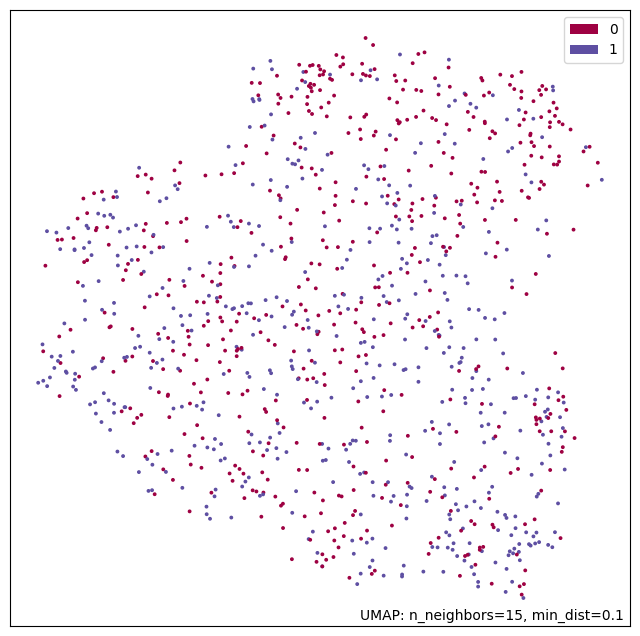

In [35]:
umap.plot.points(mapper, labels=umap_sample['Progression'])

### Toy classification with DL features

In [36]:
train_feat

,1_AF647_feat_0,1_AF647_feat_1,1_AF647_feat_2,1_AF647_feat_3,1_AF647_feat_4,1_AF647_feat_5,1_AF647_feat_6,1_AF647_feat_7,1_AF647_feat_8,1_AF647_feat_9,...,1_DAPI_feat_2045,1_DAPI_feat_2046,1_DAPI_feat_2047,Slide,ROI number,PatientID,Location,Progression,pT,Fuhrman
9432,-0.357121,0.515736,0.445700,-0.124102,0.748899,-0.229082,1.023557,-1.754389,-0.882374,-0.099811,...,-1.135688,-0.606155,-0.083625,TMA-02,105,51,2,0,1,2
12344,-0.357121,-0.666074,-0.673781,-0.124102,0.766964,-0.229082,-0.341256,0.718463,0.803779,-0.099811,...,-1.132132,-0.606155,-0.083625,TMA-02,31,43,3,0,2,2
1090,-0.357121,-0.666074,-0.674976,-0.124102,0.763563,-0.229082,-0.341256,0.719985,0.809950,-0.099811,...,0.800300,-0.606155,-0.083625,TMA-07,109,23,1,1,1,2
6596,-0.357121,-0.666074,-0.681116,-0.124102,0.765066,-0.229082,-0.341256,0.719984,0.807642,-0.099811,...,1.274125,3.513053,-0.083625,TMA-02,53,10,1,0,1,2
9174,-0.357121,0.613379,-0.139073,-0.124102,-0.560039,-0.229082,-0.341256,0.175836,-0.882374,-0.099811,...,2.045885,1.483227,-0.083625,TMA-01,81,17,3,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,-0.357121,-0.666074,-0.673441,-0.124102,0.763354,-0.229082,-0.341256,0.719837,0.817472,-0.099811,...,-1.128053,-0.606155,-0.083625,TMA-09,113,40,3,1,2,2
12170,-0.339412,1.687882,0.292317,-0.124102,-0.155997,1.221720,-0.341256,0.098877,-0.882374,-0.099811,...,0.567513,0.062022,-0.083625,TMA-09,35,59,1,1,3,3
14846,-0.357121,-0.666074,-0.553726,-0.124102,0.838304,-0.229082,-0.341256,0.744928,0.837191,-0.099811,...,0.986853,2.205356,-0.083625,TMA-04,130,68,3,0,1,1
7572,-0.357121,-0.666074,-0.681710,-0.124102,0.773083,-0.229082,-0.341256,0.713505,0.797353,-0.099811,...,1.626867,0.338169,-0.083625,TMA-01,12,58,2,0,1,2


In [37]:
med_train_feat = train_feat.groupby(["Slide","ROI number"]).median().reset_index()
med_test_feat = test_feat.groupby(["Slide","ROI number"]).median().reset_index()

In [38]:
# Use single-cell features for classification
X_train = med_train_feat[dl_featcols]
y_train = med_train_feat['Progression']
X_test = med_test_feat[dl_featcols]
y_test = med_test_feat['Progression']

In [39]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [40]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [41]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.893
Precision: 0.920
Recall: 0.858
